In [23]:
import os
import numpy as np
import pandas as pd
import feather
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [212]:
#Set top level directory, path for reading feather and output file for the results
top_wd = os.getcwd()
feather_dir = top_wd + "\\Feather"
os.makedirs(top_wd + "\\Results", exist_ok=True)
results_dir = top_wd + "\\Results"

In [ ]:
#Function for numeric conversion of sex variable
def to_numeric(dataframe):
    sex = {"Male":1,"Female":2}
    dataframe = dataframe.replace({"Sex": sex})
    return dataframe

In [75]:
#Create a dictionary for accesing all dataframes
df_dict = {}
for i in range(10):
    os.chdir(feather_dir)
    SRS = feather.read_dataframe(f"0{i+1}_srs_sample.feather") 
    Importance = feather.read_dataframe(f"0{i+1}_importance_sample.feather") 
    Synthetic = feather.read_dataframe(f"0{i+1}_synthetic_sample.feather")

    #Apply numeric conversion (Male:1, Female:2)
    SRS = to_numeric(SRS)
    Importance = to_numeric(Importance)
    Synthetic = to_numeric(Synthetic)

    df_dict[f"SRS_{i+1}"] = SRS
    df_dict[f"Importance_{i+1}"] = Importance
    df_dict[f"Synthetic_{i+1}"] = Synthetic


In [151]:
#Create a function for handeling train test split
def t_t_split(dataframe):
    #Split x and y vars (also drop personal ID identifier)
    x_var = dataframe.iloc[:,2:].drop(columns = "Personal_ID")
    y_var = dataframe.iloc[:,0]

    #Creat Train/Test split for x and y
    x_train, x_test, y_train, y_test = train_test_split(x_var, y_var, test_size = 0.25, random_state = 420)

    #Keep a copy of unscaled x_test for later comparison
    x_test_unscaled = x_test

    #Scale x var for train and test
    sc = StandardScaler()
    #Done now for convience regarding column reassignment(rather than above when x_var created)
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    x_train = pd.DataFrame(x_train, columns=x_var.columns)
    x_test = pd.DataFrame(x_test, columns=x_var.columns)

    return x_train, x_test, y_train, y_test, x_test_unscaled

In [198]:
#Loop through Sampling methods and run our NN on each one, storing the score and results
def results(df_dict, Method = "SRS"):

   s_names = ["SRS", "Importance", "Synthetic"]

   scores = pd.DataFrame(columns = s_names)
   predicts_dict = {}

   """For Method pass: SRS, Importance or Synthetic (SRS Default)"""
   for i in range(10):   
      x_train, x_test, y_train, y_test, x_test_unscaled = t_t_split(df_dict[f"{Method}_{i+1}"])

      #Run Multi-layer Perceptron regressor
      regr = MLPRegressor(random_state=420, max_iter=500, activation = "relu", solver='lbfgs').fit(x_train, y_train)
      
      #Generate Score Value
      s_v = regr.score(x_test, y_test)

      #Write If function ( if SRS: if != SRS:)

      #Add score to scores DataFrame
      scores = scores.append({Method:s_v}, ignore_index=True)

      #Once SRS is done 
      # scores.loc[i,f"{Method}"] = scores

      #Generate Predictions
      predictions = regr.predict(x_test)
      
      #Replace negative outputs with 0
      predictions = np.where(predictions < 0, 0, predictions)

      #Convert Predicitons from Ndarray to Dataframe for Concat
      predictions = pd.DataFrame(data=predictions, columns=["Predictions"])
      
      #Store Y_test, Predictions for X_test and data for X_test (For Comparision)
      fused_df = pd.concat([y_test.reset_index(drop=True), predictions, x_test_unscaled.reset_index(drop=True)], axis = 1)
      predicts_dict[f"{Method}_{i+1}"] = fused_df
   
   return scores, predicts_dict
   

In [ ]:
#Runtime for SRS: 18 minutes, 07 seconds
# scores, predicts_dict = results(df_dict)

In [216]:
os.chdir(results_dir)
# scores.index += 1
feather.write_dataframe(scores,"scores.feather")
for i in range(10):
    feather.write_dataframe(predicts_dict[f"SRS_{i+1}"],f"0{i+1}_srs_MLPR_results.feather") 
    #feather.read_dataframe(,f"0{i+1}_importance_MLPR_results.feather") 
    #feather.read_dataframe(,f"0{i+1}_synthetic_MLPR_results.feather")


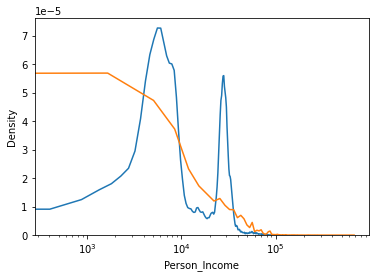

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=predictions, bw_adjust=.2)
sns.kdeplot(data=y_test, bw_adjust=0.2)
plt.xscale("log")

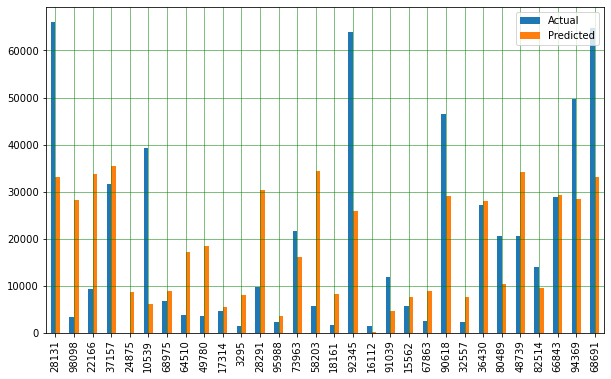

In [35]:
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df_temp = df_temp.head(30)

df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()